In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.multivariate.manova import MANOVA
from typing import List, Dict
# Importing model and pipeline specifics
from category_encoders import OrdinalEncoder, OneHotEncoder

# Pipeline specifics
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer as SI
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# ML Model training:-
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from xgboost import DMatrix, XGBClassifier
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import (RandomForestClassifier as RFC, 
                              ExtraTreesClassifier as ETC,
                              AdaBoostClassifier as ABC,
                              BaggingClassifier as BC                             
                             );
from sklearn.linear_model import LogisticRegression as LC

# Ensemble and tuning:-
import optuna;
from optuna import Trial, trial, create_study
from optuna.samplers import TPESampler, CmaEsSampler
optuna.logging.set_verbosity = optuna.logging.ERROR

pd.set_option('display.max_columns',50)
# set a nice color palette
sns.set_palette("Set2")

In [54]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
original_df = pd.read_csv('original.csv')
train_df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,None,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [55]:
# Removing the ID 
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [56]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum(), original_df.isnull().sum().sum()

(0, 0, 1602)

In [57]:
train_df.shape, test_df.shape, original_df.shape

((1235, 28), (824, 27), (299, 28))

In [58]:
# train_df.dtypes

In [59]:
train_df.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [60]:
# Define categorical and numerical features:-
cat_features = train_df.select_dtypes(include='object').columns.tolist()
num_features = train_df.select_dtypes(exclude='object').columns.tolist()

print(f'There are {len(cat_features)} categorical features: \n{cat_features}')
print(f'There are {len(num_features)} numerical features: \n{num_features}')

There are 17 categorical features: 
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'outcome']
There are 11 numerical features: 
['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']


In [61]:
# Fill in the missing values from the original dataset based on feature type
for col in cat_features:
    original_df[col].fillna(original_df[col].mode()[0], inplace=True)
for col in num_features:
    original_df[col].fillna(original_df[col].median(), inplace=True)

# Check if there are any missing values left
original_df.isnull().sum().sum()

0

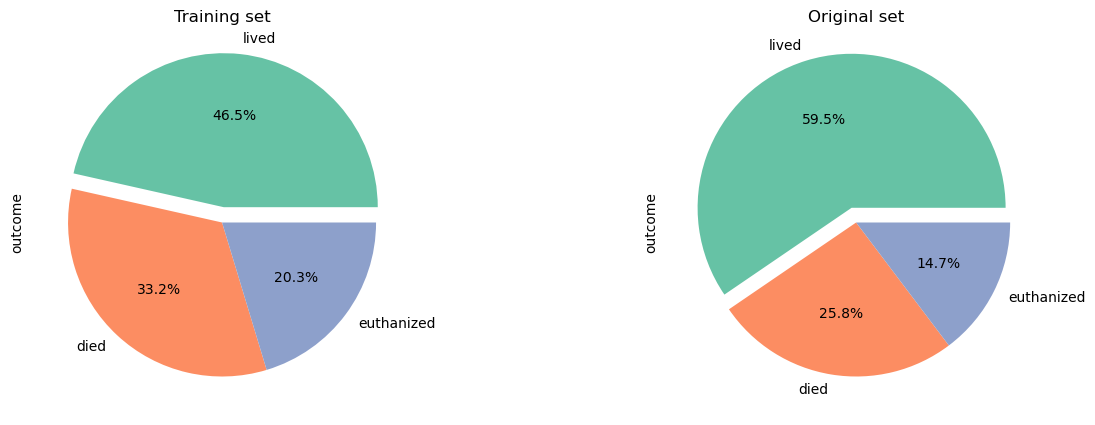

In [62]:
# Look at the target distribution of the training set vs the original set
fig, ax = plt.subplots(1,2, figsize=(15,5))
train_df['outcome'].value_counts().plot(kind='pie', ax=ax[0], autopct='%1.1f%%',
                                        explode=[0.1,0,0])
original_df['outcome'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%',
                                           explode=[0.1,0,0])
ax[0].set_title('Training set')
ax[1].set_title('Original set')
plt.show()

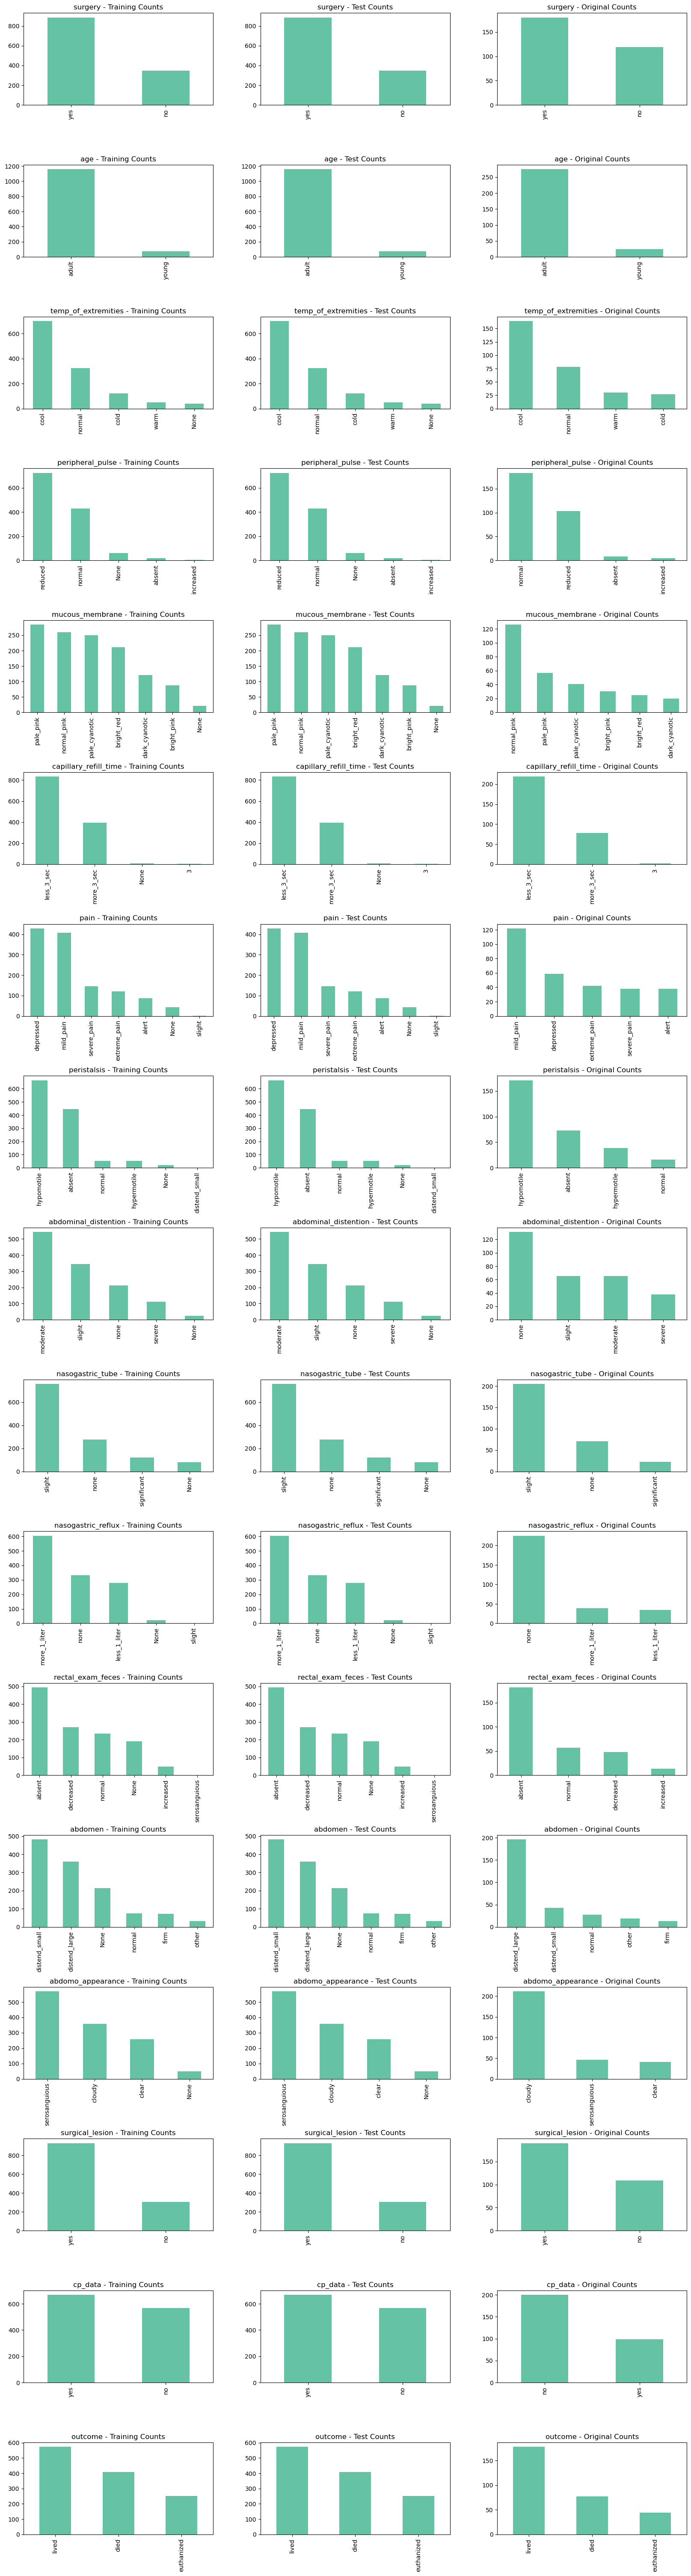

In [63]:
# category column plots
fig, axes = plt.subplots(len(cat_features), 3, figsize = (20, len(cat_features)* 4.5), 
                             gridspec_kw = {'wspace': 0.25, 'hspace': 0.65})

# bar plots for each categorical feature
for i, col in enumerate(train_df[cat_features]):
    train_df[col].value_counts().plot(kind='bar', ax=axes[i, 0], title=col)
    train_df[col].value_counts().plot(kind='bar', ax=axes[i, 1], title=col)
    original_df[col].value_counts().plot(kind='bar', ax=axes[i, 2], title=col)
    
    # set title based on feature name
    axes[i, 0].set_title(f'{col} - Training Counts')
    axes[i, 1].set_title(f'{col} - Test Counts')
    axes[i, 2].set_title(f'{col} - Original Counts')

plt.show()

/var/folders/v0/rlrtvnc53g178pfy3_fzt2wm0000gp/T/ipykernel_19678/1496699459.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source',
/var/folders/v0/rlrtvnc53g178pfy3_fzt2wm0000gp/T/ipykernel_19678/1496699459.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


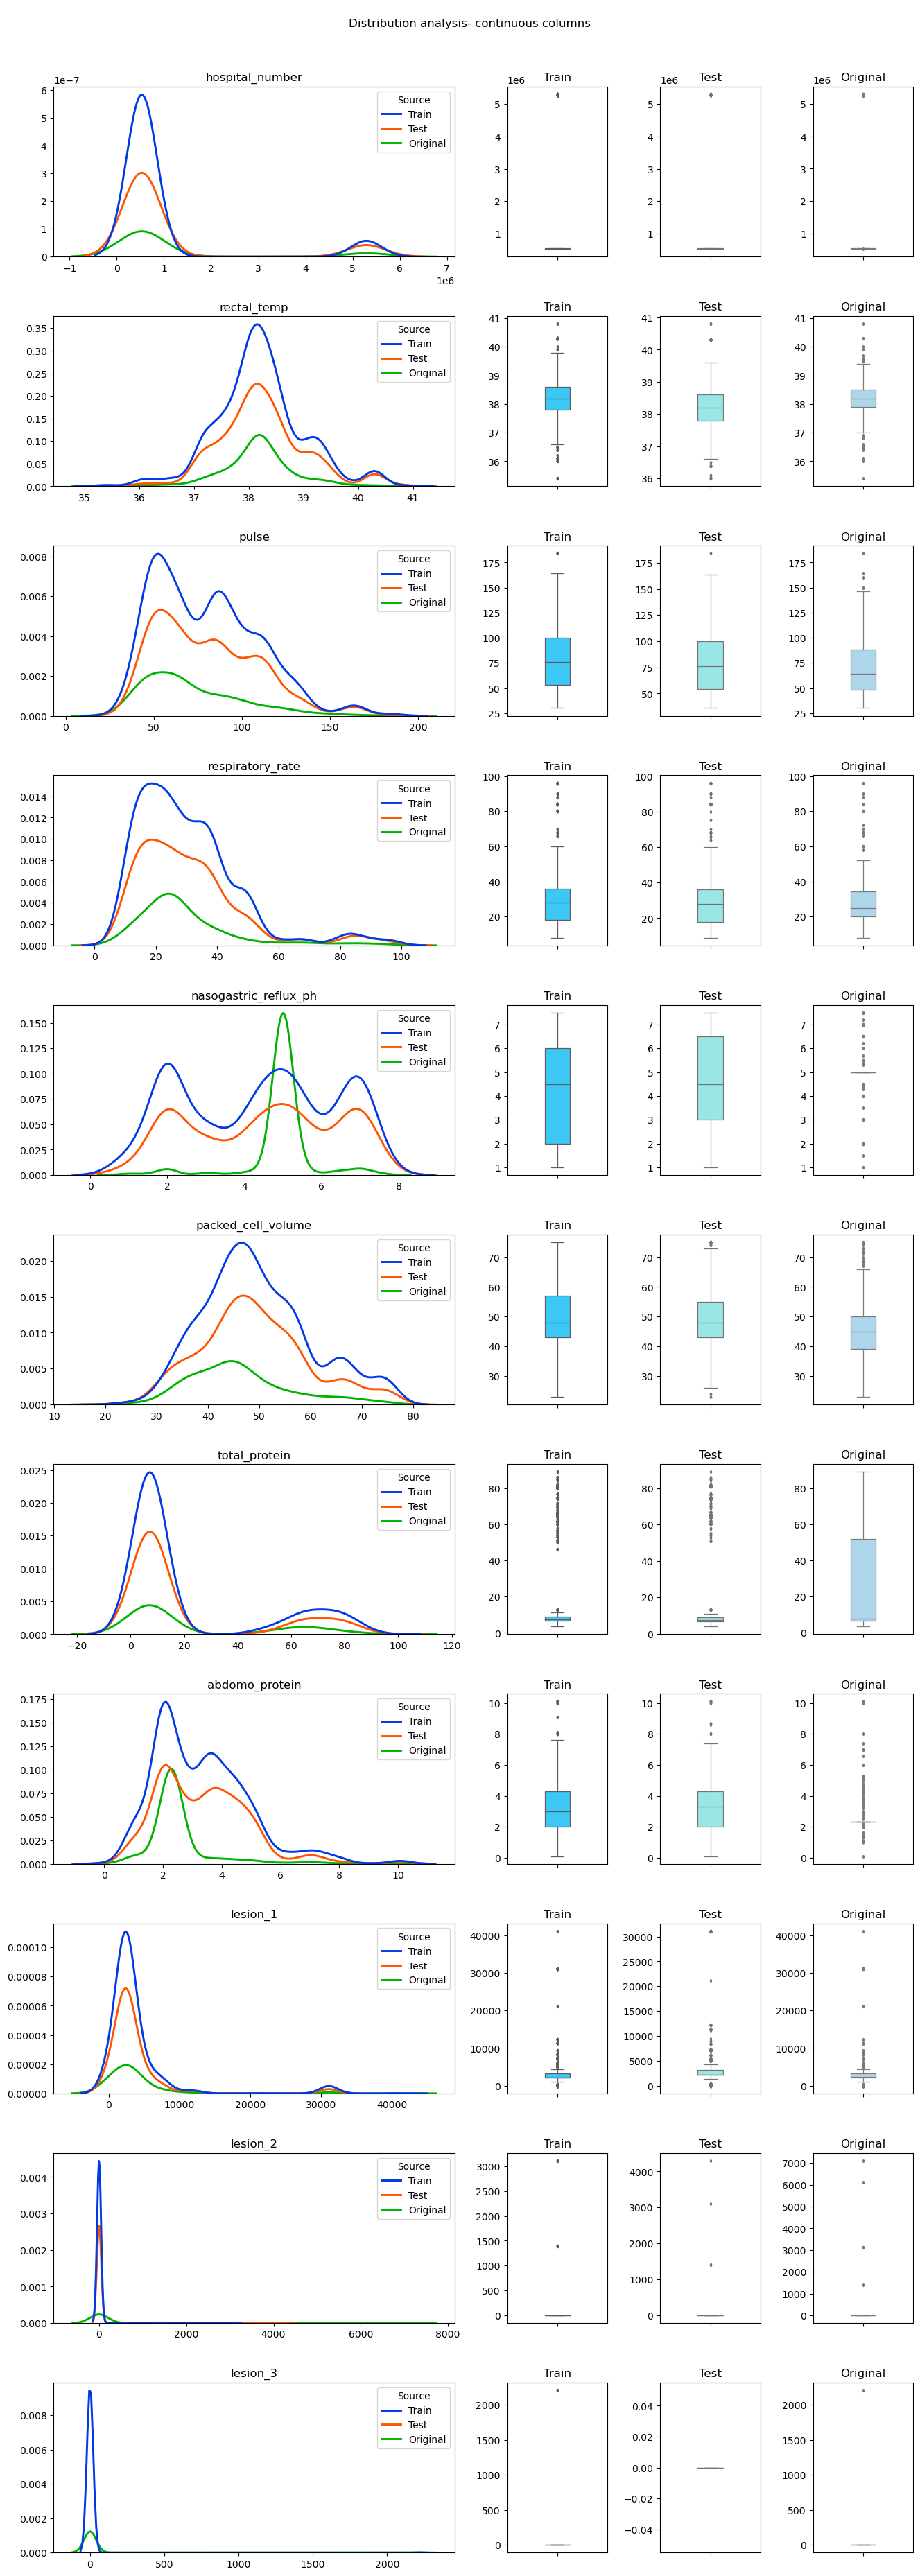

In [76]:
df = pd.concat([train_df[num_features].assign(Source = 'Train'), 
                test_df[num_features].assign(Source = 'Test'),
                original_df[num_features].assign(Source = "Original")], 
                 axis=0, ignore_index = True
                )
    
fig, axes = plt.subplots(len(num_features), 4 ,figsize = (16, len(num_features) * 4.2), 
                        gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20, 0.20]});
    
for i,col in enumerate(num_features):
        ax = axes[i,0]
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                    palette = ['#0039e6', '#ff5500', '#00b300'], 
                    ax = ax, linewidth = 2.1
                   )
        ax.set_title(f"\n{col}")
      
        ax.set(xlabel = '', ylabel = '')
        
        ax = axes[i,1]
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,
                    color = '#33ccff', saturation = 0.90, linewidth = 0.90, 
                    fliersize= 2.25,
                    ax = ax)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"Train")
        
        ax = axes[i,2]
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#80ffff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"Test")
        
        ax = axes[i,3]
        sns.boxplot(data = df.loc[df.Source == 'Original', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#99ddff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"Original")
              
plt.suptitle(f"\nDistribution analysis- continuous columns\n", 
                 y = 0.905, x = 0.50
                )
plt.tight_layout()
plt.show()


/var/folders/v0/rlrtvnc53g178pfy3_fzt2wm0000gp/T/ipykernel_19678/1203045815.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


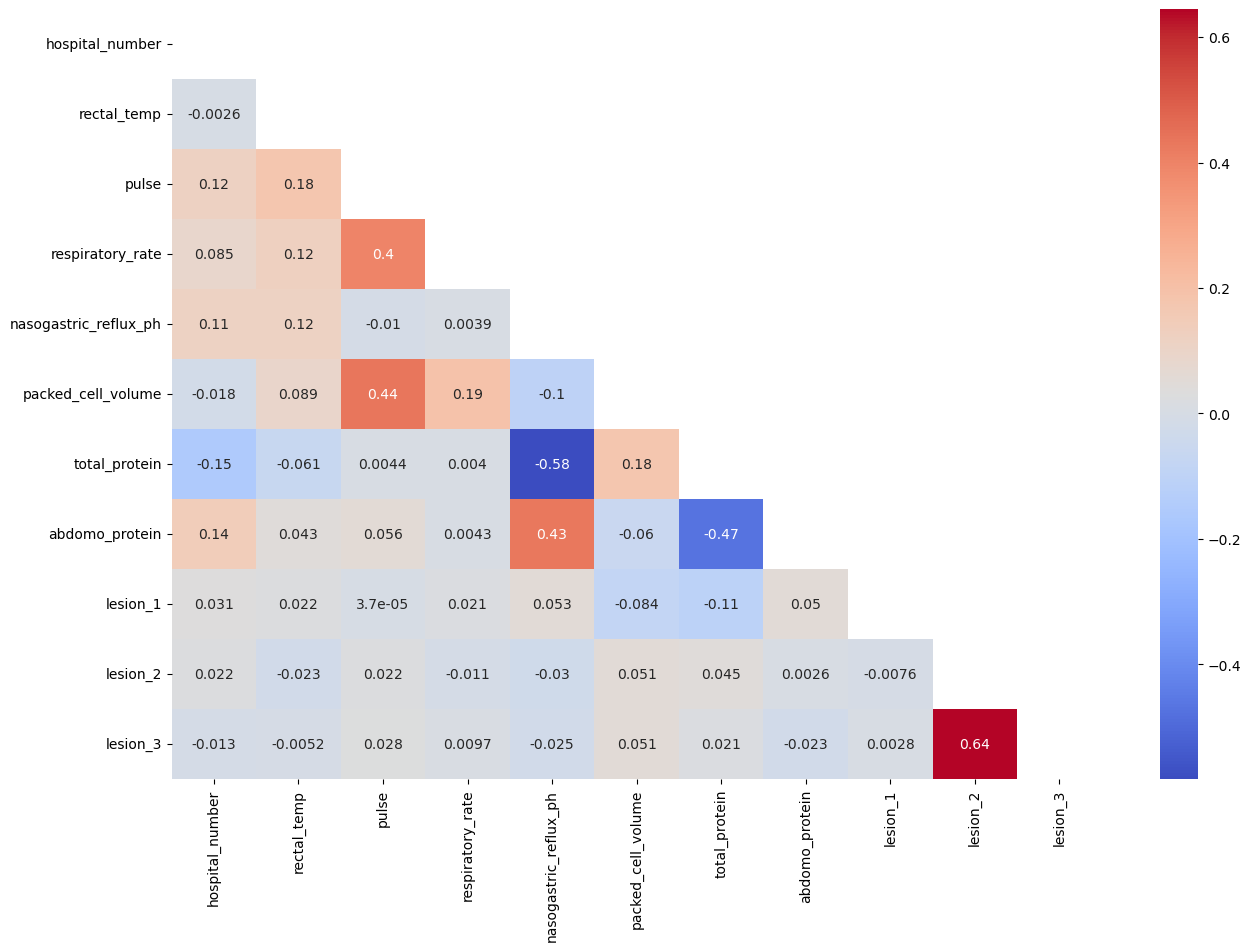

In [81]:
# correlation plot

# correlation plot for training set keeping only positive correlations
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(mask)
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

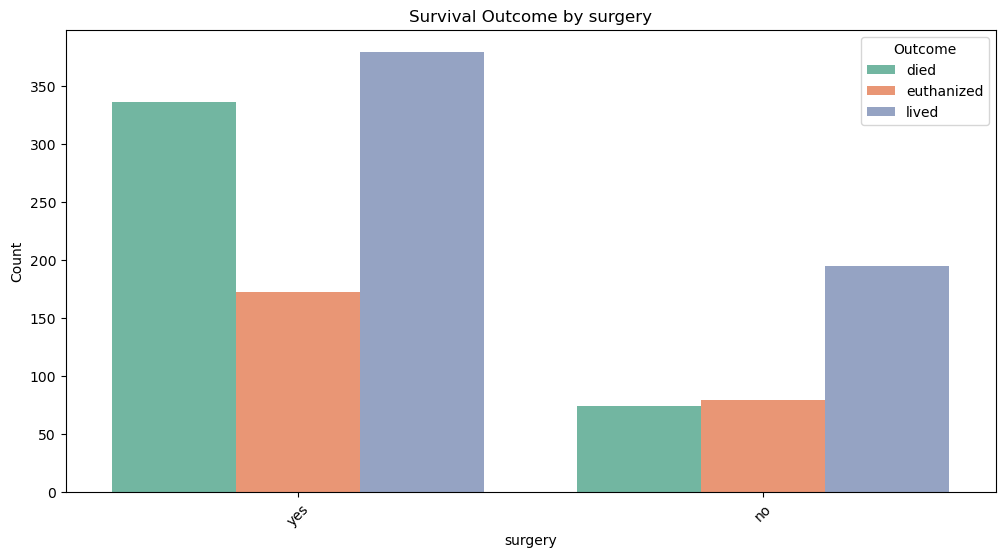

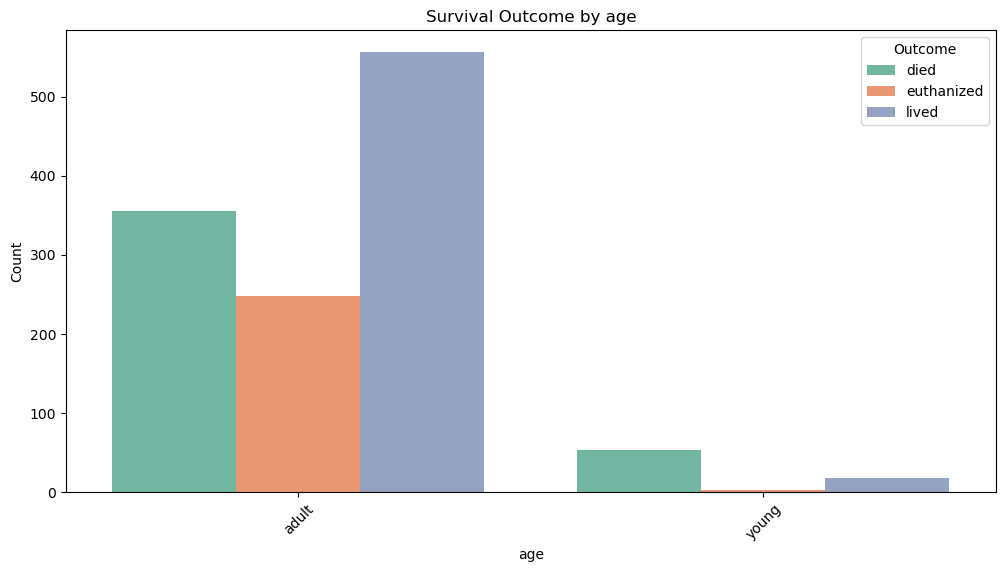

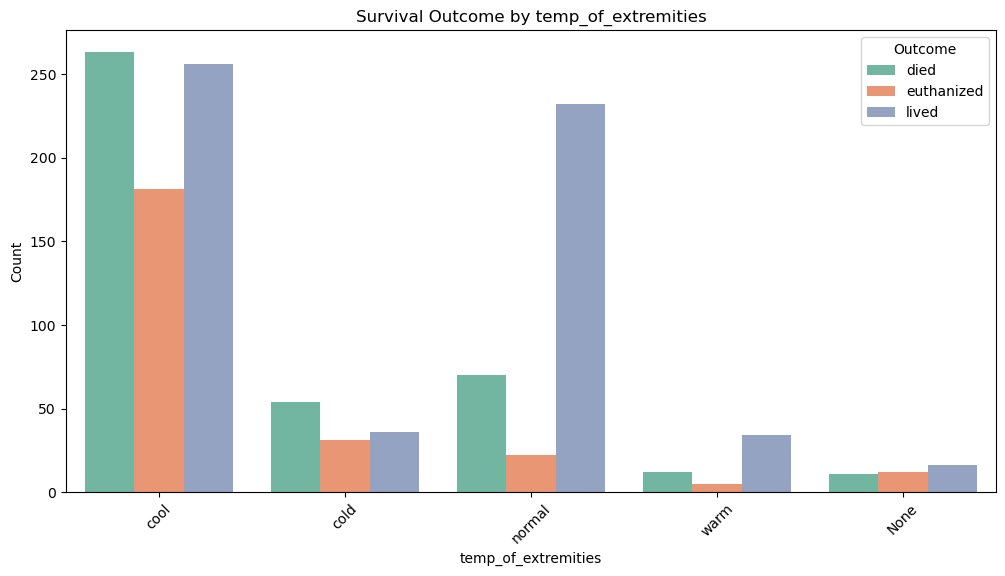

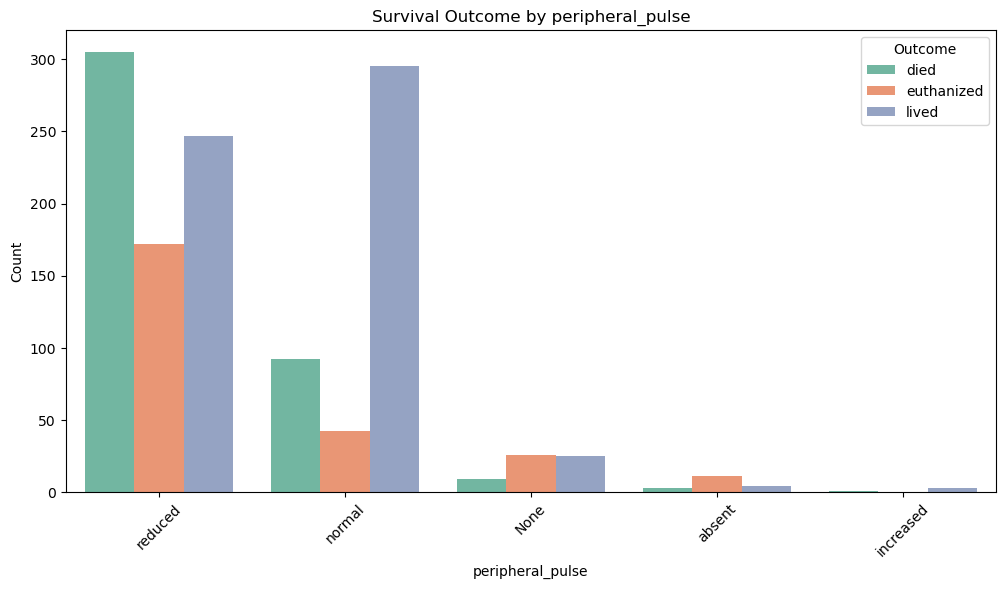

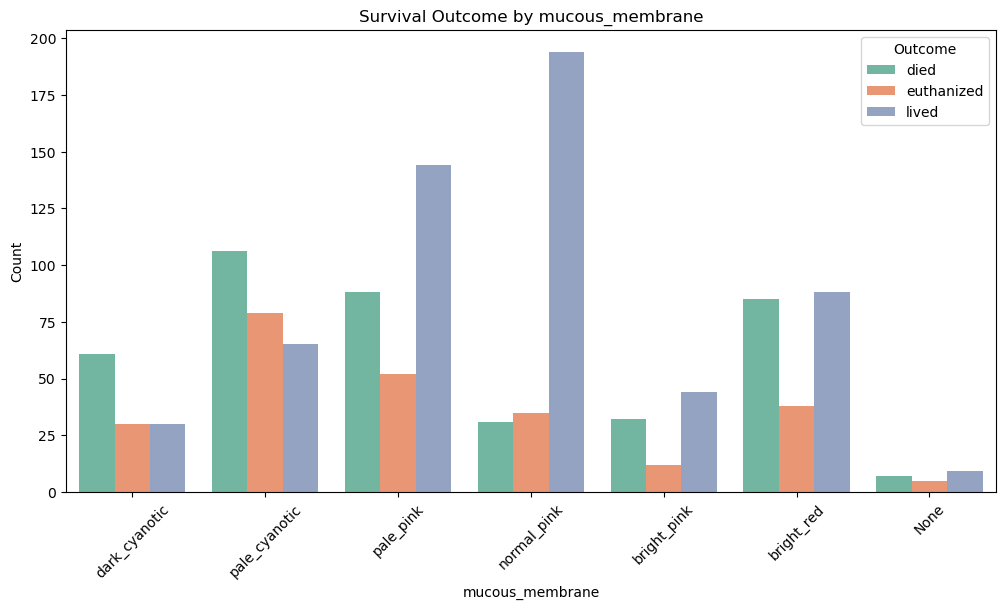

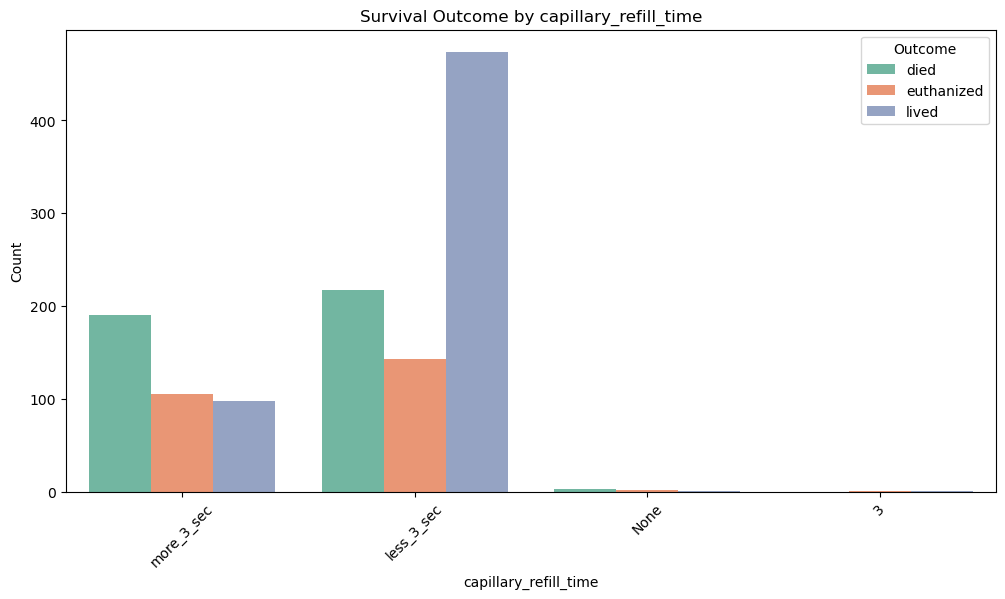

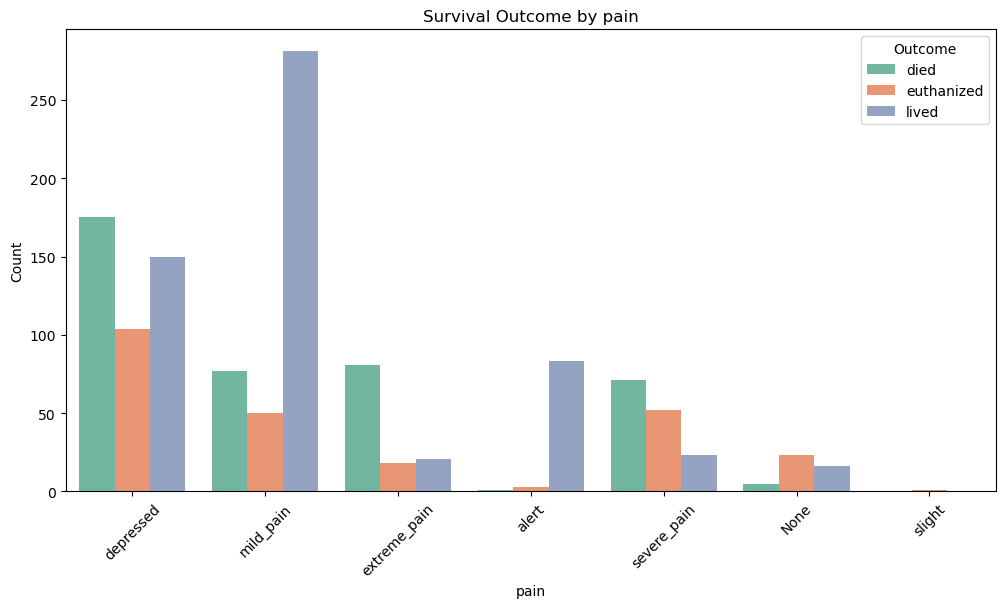

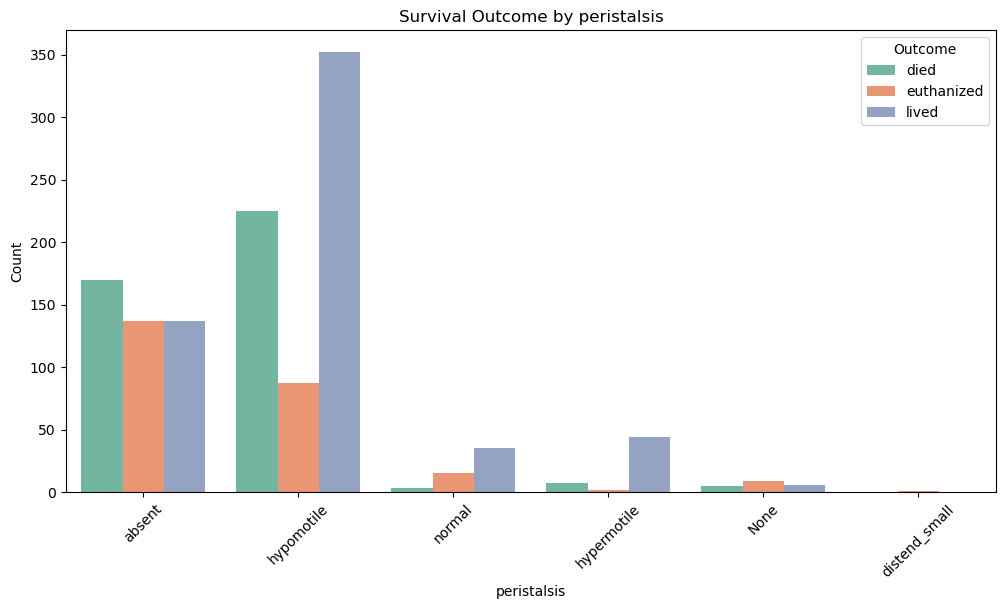

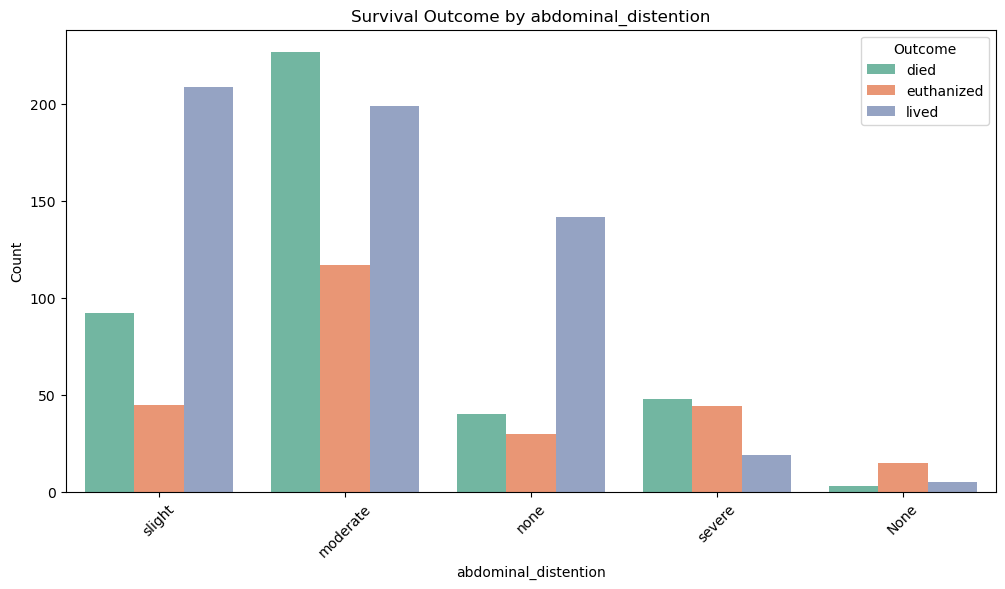

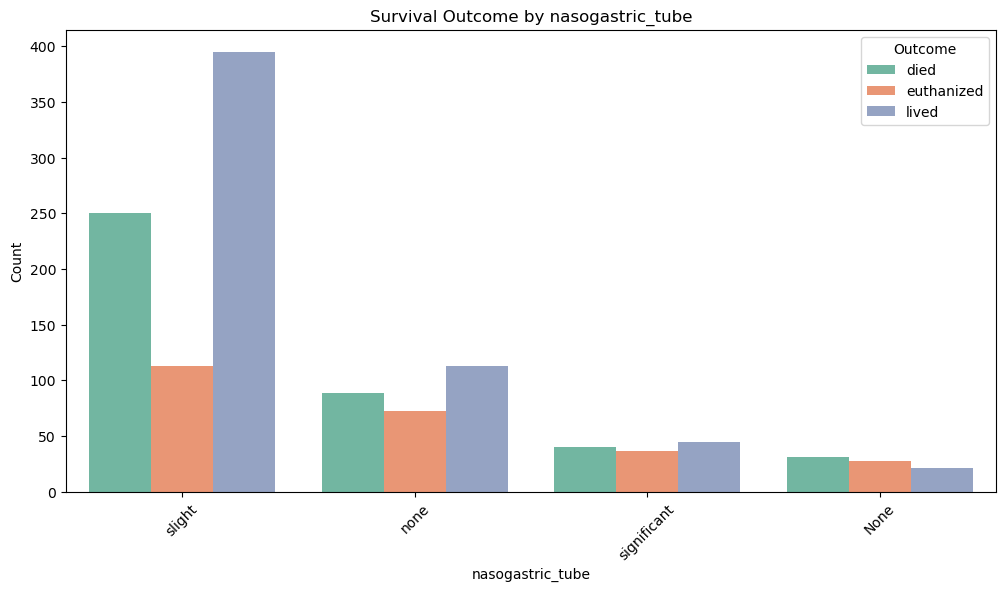

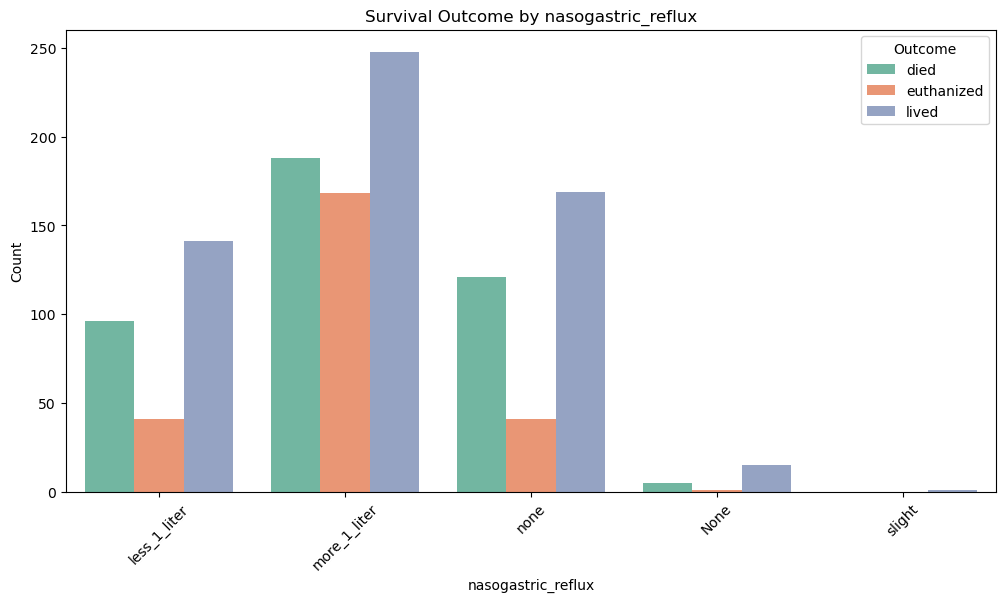

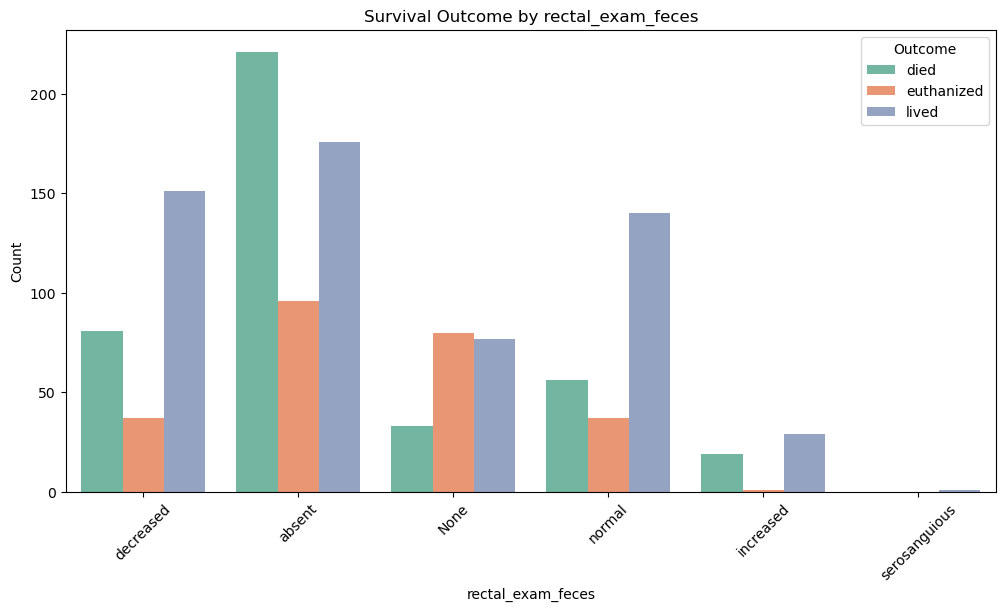

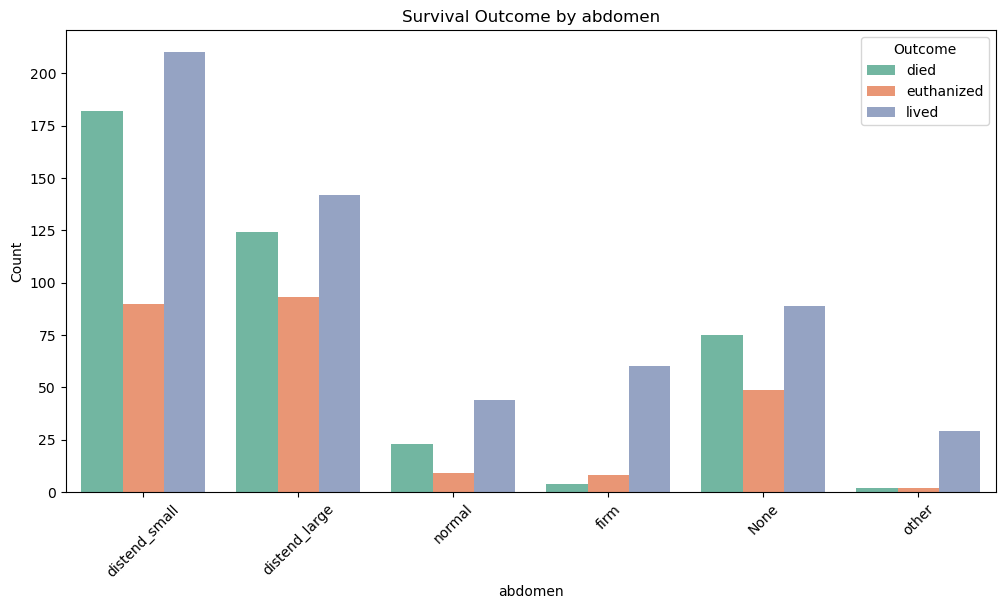

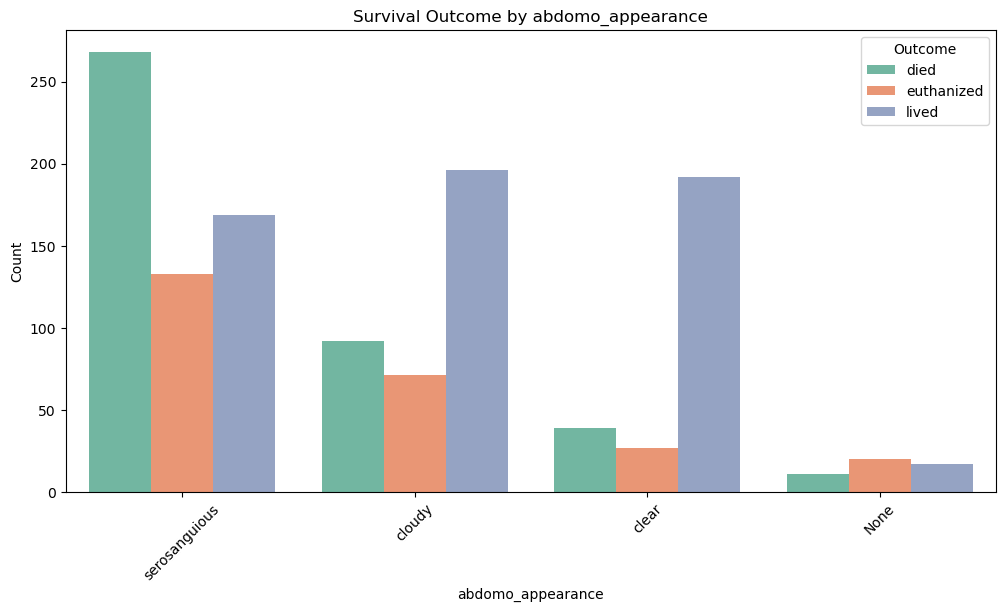

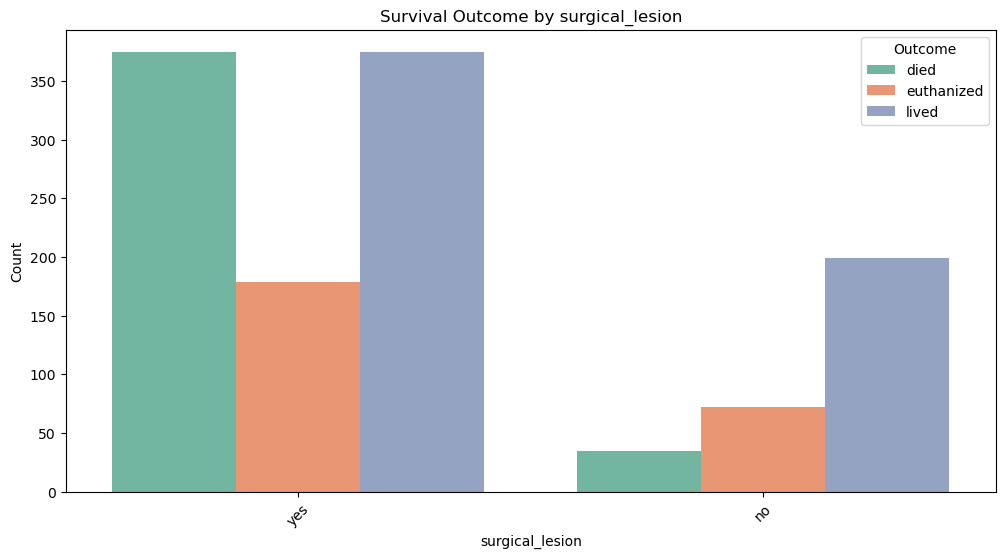

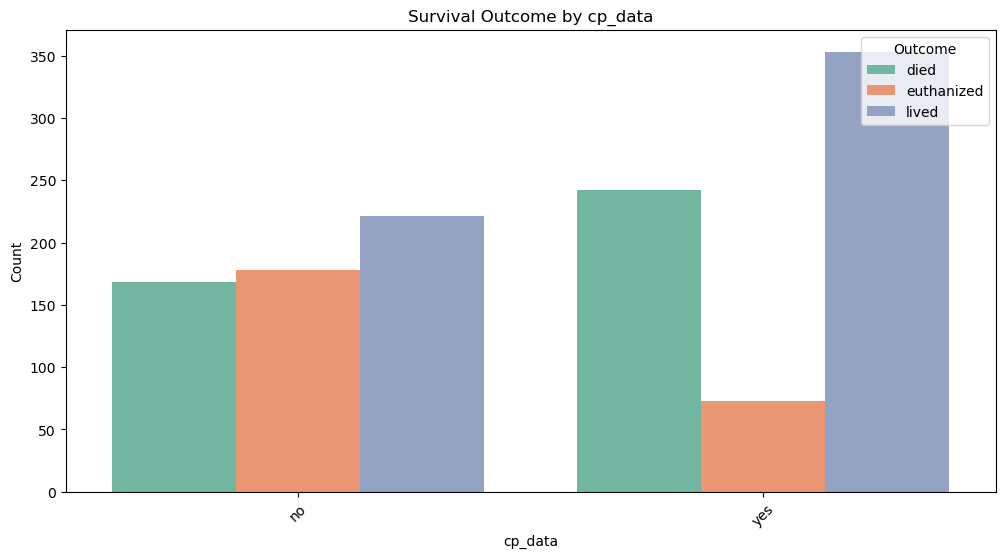

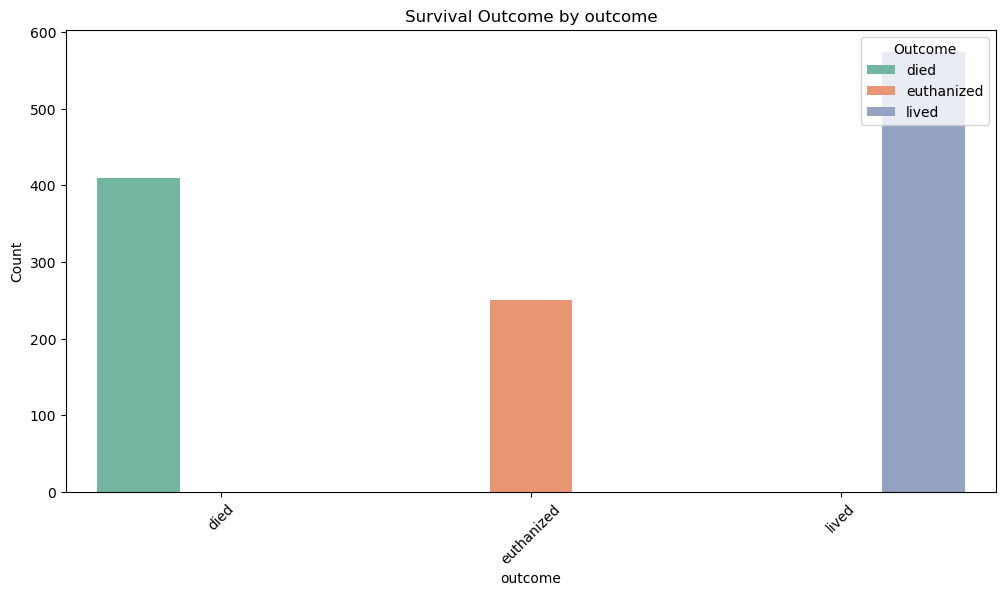

In [84]:
# looking at survival rate across categorical features
# Loop through each categorical feature and plot
for feature in cat_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_df, x=feature, hue='outcome')
    plt.title(f'Survival Outcome by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Outcome', loc='upper right')
    plt.xticks(rotation=45)
    plt.show()


### T-test to compare training to original

In [64]:
# Function to compare the distributions of the training and original datasets for each numerical feature
def compare_datasets(training_df, original_df, num_features):
    results = {}
    significance_level = 0.05
    
    for feature in num_features:
        training_data = training_df[feature]
        original_data = original_df[feature]
        
        # Perform t-test - compares mean of two samples
        t_statistic, p_value = stats.ttest_ind(training_data, original_data)
        
        # Compare the p-value to the significance level - null hypothesis is that the distributions are not different
        if p_value < significance_level:
            results[feature] = {"Result": "Significant difference", "t_statistic": t_statistic, "p_value": p_value}
        else:
            results[feature] = {"Result": "No significant difference", "t_statistic": t_statistic, "p_value": p_value}
    
    return results


comparison_results = compare_datasets(train_df, original_df, num_features)
comparison_results


{'hospital_number': {'Result': 'No significant difference',
  't_statistic': -1.4846781564005125,
  'p_value': 0.1378348190971595},
 'rectal_temp': {'Result': 'No significant difference',
  't_statistic': 0.5533257633359828,
  'p_value': 0.5801210993985999},
 'pulse': {'Result': 'Significant difference',
  't_statistic': 4.4242701964983615,
  'p_value': 1.0360179880882243e-05},
 'respiratory_rate': {'Result': 'No significant difference',
  't_statistic': 0.6189973405532775,
  'p_value': 0.5360101411615078},
 'nasogastric_reflux_ph': {'Result': 'Significant difference',
  't_statistic': -4.9369916494665,
  'p_value': 8.800581743886482e-07},
 'packed_cell_volume': {'Result': 'Significant difference',
  't_statistic': 5.095267421249975,
  'p_value': 3.914894068263701e-07},
 'total_protein': {'Result': 'No significant difference',
  't_statistic': -0.6034859924820966,
  'p_value': 0.5462747684531165},
 'abdomo_protein': {'Result': 'Significant difference',
  't_statistic': 7.56373575240060

In [73]:
# function to compare In the MANOVA approach, multiple numerical features are considered 
# simultaneously. You're asking a more holistic question: "Considering all these features 
# together, are the training and original datasets significantly different?"
# using Pillai's trace test statistic as the sample size is different between the two datasets

def perform_manova(training_df: pd.DataFrame, original_df: pd.DataFrame, num_features: List[str], significance_level: float = 0.05) -> Dict[str, Dict]:
   
    results = {}
    
    # Combine the two datasets and create a 'group' identifier
    training_df['group'] = 'training'
    original_df['group'] = 'original'
    combined_df = pd.concat([training_df, original_df], ignore_index=True)
    
    # Perform MANOVA
    manova = MANOVA.from_formula(f"{' + '.join(num_features)} ~ group", data=combined_df)
    fit_result = manova.mv_test()
    
    # Extract and store results
    summary_frame = fit_result.summary_frame
    for test_stat in ['Pillai_Trace']: #, 'Wilks_Lambda', 'Hotelling_Lawley', 'Roy's greatest root']:
        p_value = summary_frame.loc['group', 'Pr > F'].iloc[0]
        significance = "Significant difference" if p_value < significance_level else "No significant difference"
        results[test_stat] = {"p_value": p_value, "significance": significance}
    
    return results


manova_results = perform_manova(train_df, original_df, num_features)
manova_results  


{'Pillai_Trace': {'p_value': 3.938793738543764e-30,
  'significance': 'Significant difference'}}

- Original dataset is small, was missing lots of values and shows siginifcant differences according the ttest and monova comparison so I will be excluding it in my training. 
- Quite a few features have outliers. Outlier handling may be another differentiator in this challenge. 
- Certain categorical features have label outliers that are handled while encoding
- Columns are not highly correlated. Dimensionality reduction may help here
We will need to encode lots of object columns with different encoder types
- Certain key inferences regarding columns (survival) are as below-
        - Adults
        - Non-surgical treatments
        - Normal values in health risk indicators
- Lesion 3 is a quasi-constant feature and is superfluous as it is 0 in the test set